In [1]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00a 0:00:01


In [30]:
import pandas as pd
from functools import reduce
import torch
import networkx as nx
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import ast
from transformers import AutoTokenizer, AutoModel
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F

In [3]:
news_df = pd.read_csv("/kaggle/input/graph-news/news.csv", delimiter=";")
news_df.drop_duplicates(subset=["link", "content"], inplace=True)
news_df.fillna({"post_links": "[]"}, inplace=True)
news_df = news_df[~news_df["content"].isna()]
news_df["post_links"] = news_df["post_links"].apply(lambda x: ast.literal_eval(x))

In [4]:
news_nodes = {}
for _, row in news_df.iterrows():
    news_nodes[row["link"]] = 1

news_df["post_links"] = news_df["post_links"].apply(lambda x: [link for link in x if link in news_nodes])

In [5]:
cnt = 0
for _, row in news_df.iterrows():
    cnt += len(row["post_links"])
cnt, news_df.shape[0]

(2240, 7351)

# Создадим граф из наших данных

In [6]:
def encode_texts(texts, batch_size=512):
    tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
    model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="text encoding"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
        embeddings.append(batch_embeddings)
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

In [7]:
def create_edge_index(df):
    link2id = {link:ID for ID, link in enumerate(df["link"].tolist())}
    id2link = {ID:link for link, ID in link2id.items()}
    from_nodes = [[link2id[row["link"]]] * len(row["post_links"]) for _, row in df.iterrows() if len(row["post_links"]) > 0]
    from_nodes = reduce(lambda x, y: x + y, from_nodes)
    to_nodes = [[link2id[node] for node in row["post_links"]] for _, row in df.iterrows() if len(row["post_links"]) > 0]
    to_nodes = reduce(lambda x, y: x + y, to_nodes)
    edge_index = torch.tensor([from_nodes, to_nodes])
    return edge_index, link2id, id2link

In [8]:
embeddings = encode_texts(news_df["content"].tolist(), batch_size=128)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

text encoding: 100%|██████████| 58/58 [01:09<00:00,  1.21s/it]


In [9]:
embeddings_tensors = torch.tensor(embeddings)

In [10]:
edge_index, link2id, id2link = create_edge_index(news_df)
negative_edges = negative_sampling(edge_index, num_nodes=7351)
negative_edges

tensor([[1455, 2273, 2242,  ..., 3371, 4636, 4091],
        [5007, 1966, 6592,  ..., 4185, 6924, 5007]])

In [11]:
num_edges = edge_index.shape[1]
train_edge_index_idx, val_test_edge_index_idx = train_test_split(range(num_edges), random_state=42, train_size=0.8)
val_edge_index_idx, test_edge_index_idx = train_test_split(val_test_edge_index_idx, random_state=42, train_size=0.5)

In [12]:
train_edge_index = edge_index[:, train_edge_index_idx]
val_edge_index = edge_index[:, train_edge_index_idx + val_edge_index_idx]
test_edge_index = edge_index[:, train_edge_index_idx + test_edge_index_idx]
train_edge_index.shape, val_edge_index.shape, test_edge_index.shape

(torch.Size([2, 1792]), torch.Size([2, 2016]), torch.Size([2, 2016]))

In [13]:
assert len(train_edge_index_idx) + len(val_edge_index_idx) + len(test_edge_index_idx) == num_edges
assert len(set(train_edge_index_idx) & set(val_edge_index_idx)) == 0
assert len(set(train_edge_index_idx) & set(test_edge_index_idx)) == 0
assert len(set(test_edge_index_idx) & set(val_edge_index_idx)) == 0

In [18]:
train_data = Data(x=embeddings_tensors, edge_index=train_edge_index)
val_data = Data(x=embeddings_tensors, edge_index=val_edge_index)
test_data = Data(x=embeddings_tensors, edge_index=test_edge_index)

In [19]:
only_val_edge_index = edge_index[:, val_edge_index_idx]
only_test_edge_index = edge_index[:, test_edge_index_idx]

In [20]:
negative_edges = negative_sampling(edge_index, num_nodes=7351)
train_negative_edges = negative_edges[:, :int(0.8*num_edges)]
val_negative_edges = negative_edges[:, int(0.8*num_edges):int(0.9*num_edges)]
test_negative_edges = negative_edges[:, int(0.9*num_edges):]

In [13]:
class SimpleLinkPredictionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        torch.manual_seed(42)
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.lin3 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index, negative_edges):
        pos_embs = x[edge_index[0, :]] * x[edge_index[1, :]]
        neg_embs = x[negative_edges[0, :]] * x[negative_edges[1, :]]
        pos_preds = self.sigmoid(self.lin3(self.relu(self.lin2(self.relu(self.lin1(pos_embs))))))
        neg_preds = self.sigmoid(self.lin3(self.relu(self.lin2(self.relu(self.lin1(neg_embs))))))
        return pos_preds, neg_preds

    def validate(self, x, edge_index, negative_edges, val_edge_index=None):
        pos_embs = x[val_edge_index[0, :]] * x[val_edge_index[1, :]]
        neg_embs = x[negative_edges[0, :]] * x[negative_edges[1, :]]
        pos_preds = self.sigmoid(self.lin3(self.relu(self.lin2(self.relu(self.lin1(pos_embs))))))
        neg_preds = self.sigmoid(self.lin3(self.relu(self.lin2(self.relu(self.lin1(neg_embs))))))
        return pos_preds, neg_preds

In [14]:
class GCNLinkPredictionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, conv_type="gcn"):
        super().__init__()
        torch.manual_seed(42)
        if conv_type == "gcn":
            self.conv1 = GCNConv(input_dim, hidden_dim)
        else:
            self.conv1 = GATConv(input_dim, hidden_dim)
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.lin3 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index, negative_edges):
        x = self.conv1(x, edge_index)
        pos_embs = x[edge_index[0, :]] * x[edge_index[1, :]]
        neg_embs = x[negative_edges[0, :]] * x[negative_edges[1, :]]
        pos_preds = self.sigmoid(self.lin3(self.relu(self.lin2(self.relu(self.lin1(pos_embs))))))
        neg_preds = self.sigmoid(self.lin3(self.relu(self.lin2(self.relu(self.lin1(neg_embs))))))
        return pos_preds, neg_preds

    def validate(self, x, edge_index, negative_edges, val_edge_index=None):
        x = self.conv1(x, edge_index)
        pos_embs = x[val_edge_index[0, :]] * x[val_edge_index[1, :]]
        neg_embs = x[negative_edges[0, :]] * x[negative_edges[1, :]]
        pos_preds = self.sigmoid(self.lin3(self.relu(self.lin2(self.relu(self.lin1(pos_embs))))))
        neg_preds = self.sigmoid(self.lin3(self.relu(self.lin2(self.relu(self.lin1(neg_embs))))))
        return pos_preds, neg_preds

In [15]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train")
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="val")
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label="train")
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label="val")

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale("log")

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale("log")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    axs[0].set_ylabel("loss")
    axs[1].set_ylabel("accuracy")
    plt.show()

# Простая модель

In [16]:
simple_model = SimpleLinkPredictionModel(312, 312)
optimizer = torch.optim.Adam(simple_model.parameters())
criterion = nn.BCELoss()

In [21]:
epochs = 100
train_history = []
train_acc_history = []
val_history = []
val_acc_history = []
for epoch in range(epochs):
    pos_preds, neg_preds = simple_model(train_data.x, train_data.edge_index, train_negative_edges)
    pos_target = torch.ones(pos_preds.shape[0])
    neg_target = torch.zeros(neg_preds.shape[0])
    preds = torch.concat([pos_preds, neg_preds]).reshape((pos_preds.shape[0] + neg_preds.shape[0],))
    target = torch.concat([pos_target, neg_target])
    loss = criterion(preds, target)
    train_history.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    preds = (preds > 0.5).detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    acc = accuracy_score(target, preds)
    train_acc_history.append(acc)
    with torch.no_grad():
        pos_preds, neg_preds = simple_model.validate(
            val_data.x,
            val_data.edge_index,
            val_negative_edges,
            val_edge_index=only_val_edge_index
        )
        pos_target = torch.ones(pos_preds.shape[0])
        neg_target = torch.zeros(neg_preds.shape[0])
        preds = torch.concat([pos_preds, neg_preds]).reshape((pos_preds.shape[0] + neg_preds.shape[0],))
        target = torch.concat([pos_target, neg_target])
        loss = criterion(preds, target)
        val_history.append(loss.item())
        preds = (preds > 0.5).detach().cpu().numpy()
        target = target.detach().cpu().numpy()
        acc = accuracy_score(target, preds)
        val_acc_history.append(acc)

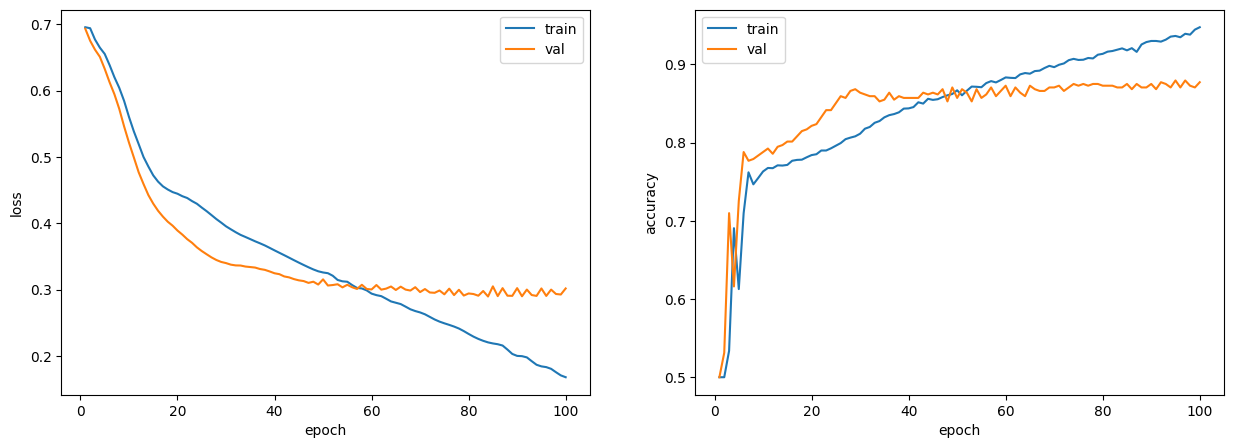

In [22]:
plot_losses(train_history, train_acc_history, val_history, val_acc_history)

In [23]:
with torch.no_grad():
    pos_preds, neg_preds = simple_model.validate(
        test_data.x,
        test_data.edge_index,
        test_negative_edges,
        val_edge_index=only_test_edge_index
    )
    pos_target = torch.ones(pos_preds.shape[0])
    neg_target = torch.zeros(neg_preds.shape[0])
    preds = torch.concat([pos_preds, neg_preds]).reshape((pos_preds.shape[0] + neg_preds.shape[0],))
    target = torch.concat([pos_target, neg_target])
    preds = (preds > 0.5).detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    acc = accuracy_score(target, preds)
print("baseline test acc: ", acc)

baseline test acc:  0.8348214285714286


# Графовая нейросеть

In [25]:
model = GCNLinkPredictionModel(312, 312)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()

In [26]:
epochs = 100
train_history = []
train_acc_history = []
val_history = []
val_acc_history = []
for epoch in range(epochs):
    pos_preds, neg_preds = model(train_data.x, train_data.edge_index, train_negative_edges)
    pos_target = torch.ones(pos_preds.shape[0])
    neg_target = torch.zeros(neg_preds.shape[0])
    preds = torch.concat([pos_preds, neg_preds]).reshape((pos_preds.shape[0] + neg_preds.shape[0],))
    target = torch.concat([pos_target, neg_target])
    loss = criterion(preds, target)
    train_history.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    preds = (preds > 0.5).detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    acc = accuracy_score(target, preds)
    train_acc_history.append(acc)
    with torch.no_grad():
        pos_preds, neg_preds = model.validate(
            val_data.x,
            val_data.edge_index,
            val_negative_edges,
            val_edge_index=only_val_edge_index
        )
        pos_target = torch.ones(pos_preds.shape[0])
        neg_target = torch.zeros(neg_preds.shape[0])
        preds = torch.concat([pos_preds, neg_preds]).reshape((pos_preds.shape[0] + neg_preds.shape[0],))
        target = torch.concat([pos_target, neg_target])
        loss = criterion(preds, target)
        val_history.append(loss.item())
        preds = (preds > 0.5).detach().cpu().numpy()
        target = target.detach().cpu().numpy()
        acc = accuracy_score(target, preds)
        val_acc_history.append(acc)

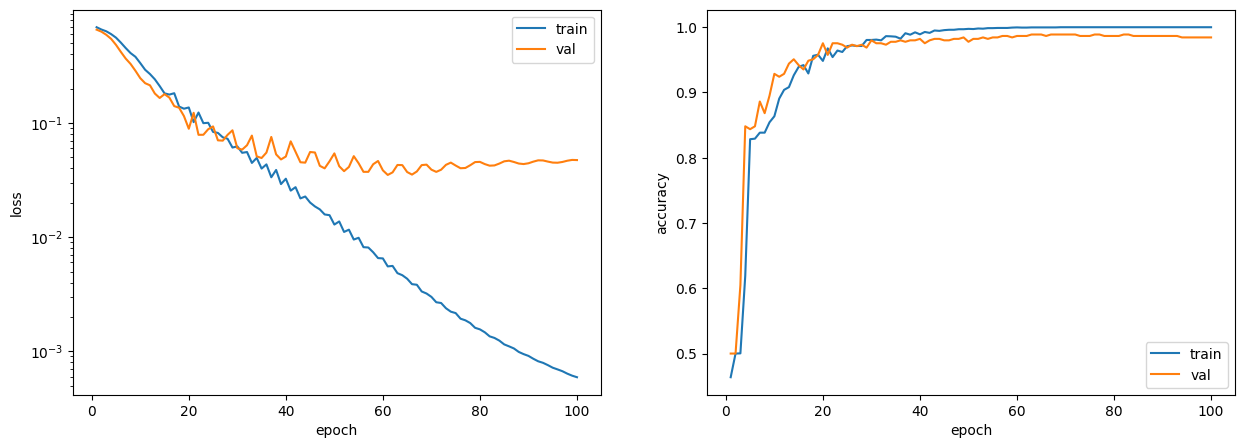

In [27]:
plot_losses(train_history, train_acc_history, val_history, val_acc_history)

In [28]:
with torch.no_grad():
    pos_preds, neg_preds = model.validate(
        test_data.x,
        test_data.edge_index,
        test_negative_edges,
        val_edge_index=only_test_edge_index
    )
    pos_target = torch.ones(pos_preds.shape[0])
    neg_target = torch.zeros(neg_preds.shape[0])
    preds = torch.concat([pos_preds, neg_preds]).reshape((pos_preds.shape[0] + neg_preds.shape[0],))
    target = torch.concat([pos_target, neg_target])
    preds = (preds > 0.5).detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    acc = accuracy_score(target, preds)
print("test acc: ", acc)

test acc:  0.9821428571428571


# Модель со слоем GAT

In [31]:
model_gat = GCNLinkPredictionModel(312, 312, conv_type="GAT")
optimizer = torch.optim.Adam(model_gat.parameters())
criterion = nn.BCELoss()

In [32]:
epochs = 100
train_history = []
train_acc_history = []
val_history = []
val_acc_history = []
for epoch in range(epochs):
    pos_preds, neg_preds = model_gat(train_data.x, train_data.edge_index, train_negative_edges)
    pos_target = torch.ones(pos_preds.shape[0])
    neg_target = torch.zeros(neg_preds.shape[0])
    preds = torch.concat([pos_preds, neg_preds]).reshape((pos_preds.shape[0] + neg_preds.shape[0],))
    target = torch.concat([pos_target, neg_target])
    loss = criterion(preds, target)
    train_history.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    preds = (preds > 0.5).detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    acc = accuracy_score(target, preds)
    train_acc_history.append(acc)
    with torch.no_grad():
        pos_preds, neg_preds = model_gat.validate(
            val_data.x,
            val_data.edge_index,
            val_negative_edges,
            val_edge_index=only_val_edge_index
        )
        pos_target = torch.ones(pos_preds.shape[0])
        neg_target = torch.zeros(neg_preds.shape[0])
        preds = torch.concat([pos_preds, neg_preds]).reshape((pos_preds.shape[0] + neg_preds.shape[0],))
        target = torch.concat([pos_target, neg_target])
        loss = criterion(preds, target)
        val_history.append(loss.item())
        preds = (preds > 0.5).detach().cpu().numpy()
        target = target.detach().cpu().numpy()
        acc = accuracy_score(target, preds)
        val_acc_history.append(acc)

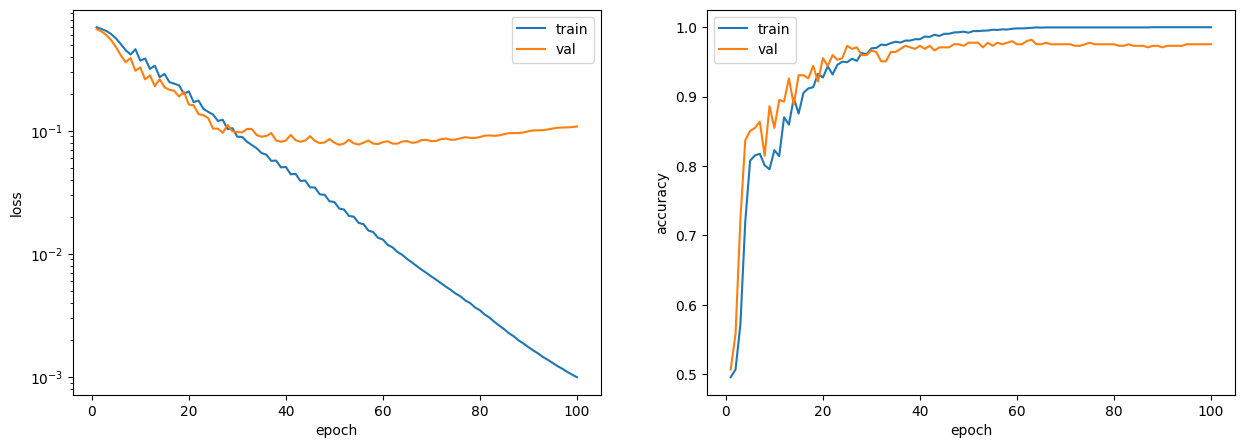

In [33]:
plot_losses(train_history, train_acc_history, val_history, val_acc_history)

In [34]:
with torch.no_grad():
    pos_preds, neg_preds = model_gat.validate(
        test_data.x,
        test_data.edge_index,
        test_negative_edges,
        val_edge_index=only_test_edge_index
    )
    pos_target = torch.ones(pos_preds.shape[0])
    neg_target = torch.zeros(neg_preds.shape[0])
    preds = torch.concat([pos_preds, neg_preds]).reshape((pos_preds.shape[0] + neg_preds.shape[0],))
    target = torch.concat([pos_target, neg_target])
    preds = (preds > 0.5).detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    acc = accuracy_score(target, preds)
print("test acc: ", acc)

test acc:  0.9642857142857143
